<a href="https://colab.research.google.com/github/sharathchandran2001/GeneralUtils/blob/main/1_quantum_log_lstm_preditionV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Install required packages
!pip install pennylane matplotlib scikit-learn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.9 MB/s eta 0:00:00


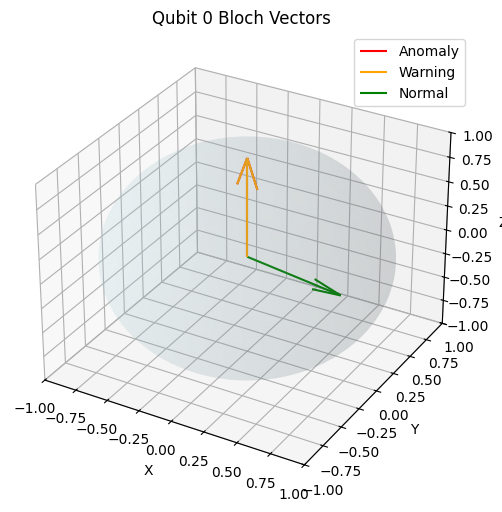

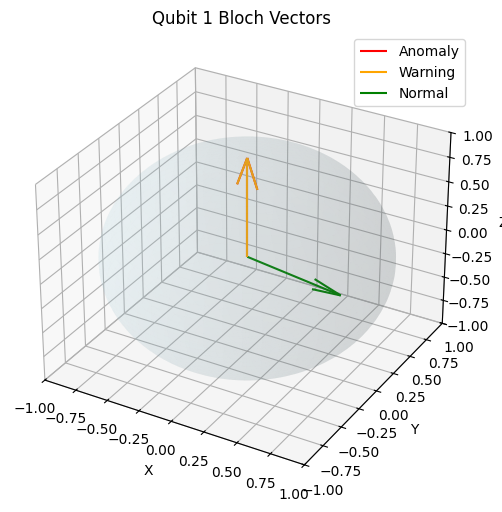

In [9]:
# ✅ Import libraries
import pennylane as qml
from pennylane import numpy as np  # quantum-safe NumPy
import numpy as onp                # standard NumPy for plotting
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# ✅ Step 1: Sample logs
logs = [
    "disk read error on sector 44",             # Anomaly
    "CPU temperature warning threshold hit",    # Warning
    # "user login successful from IP 192.168.1.1",             # Anomaly
    # "user login successful from IP 192.168.1.1",    # Warning
    "user login successful from IP 192.168.1.1" # Normal
]
log_labels = ["Anomaly", "Warning", "Normal"]
colors = ["red", "orange", "green"]

# ✅ Step 2: TF-IDF to 2D feature vectors
vectorizer = TfidfVectorizer(max_features=2)
X = vectorizer.fit_transform(logs).toarray()
X_scaled = np.clip(X, 0, 1)

# ✅ Step 3: Quantum device + encoding circuit
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def encode_logs_to_qubits(log_vector):
    angles = log_vector * np.pi
    qml.RY(angles[0], wires=0)
    qml.RY(angles[1], wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.density_matrix(wires=[0, 1])

# ✅ Step 4: Bloch vector calculation
def compute_bloch_vector(rho):
    paulis = [qml.PauliX(0).matrix(), qml.PauliY(0).matrix(), qml.PauliZ(0).matrix()]
    return np.real([np.trace(rho @ p) for p in paulis])

def bloch_coords_from_density_matrix(full_rho, qubit):
    rho_reshaped = full_rho.reshape(2, 2, 2, 2)
    if qubit == 0:
        reduced = np.trace(rho_reshaped, axis1=2, axis2=3)
    else:
        reduced = np.trace(rho_reshaped, axis1=0, axis2=1)
    return compute_bloch_vector(reduced)

# ✅ Step 5: Encode logs and extract Bloch vectors
bloch_data_q0 = []
bloch_data_q1 = []

for log_vec in X_scaled:
    full_rho = encode_logs_to_qubits(log_vec)
    bloch_data_q0.append(bloch_coords_from_density_matrix(full_rho, 0))
    bloch_data_q1.append(bloch_coords_from_density_matrix(full_rho, 1))

# ✅ Step 6: Plot Bloch spheres using standard NumPy
def plot_bloch_vectors(qubit_index, vectors, labels, colors):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Bloch sphere surface using standard numpy
    u, v = onp.mgrid[0:2*onp.pi:100j, 0:onp.pi:100j]
    x = onp.cos(u)*onp.sin(v)
    y = onp.sin(u)*onp.sin(v)
    z = onp.cos(v)
    ax.plot_surface(x, y, z, color='lightblue', alpha=0.1)

    # Plot each vector
    for vec, label, color in zip(vectors, labels, colors):
        ax.quiver(0, 0, 0, *vec, color=color, label=label)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"Qubit {qubit_index} Bloch Vectors")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

# ✅ Step 7: Visualize both qubits
plot_bloch_vectors(0, bloch_data_q0, log_labels, colors)
plot_bloch_vectors(1, bloch_data_q1, log_labels, colors)
